In [8]:
# Cell 1: Imports and experiment configuration

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import graphical_lasso, ledoit_wolf  # <- add ledoit_wolf

%matplotlib widget
import matplotlib.pyplot as plt

# If you want to also have your external script available:
# import calculate_glasso

# Experiment configuration
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'SPY', 'QQQ', 'GLD']  # or your full universe
START_DATE = "2023-01-01"
END_DATE = "2024-01-01"

ALPHA = 0.4                      # Graphical Lasso regularization parameter
WINDOW_WEEKS = 2
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK  # approx 10 trading days

print("Config loaded.")
print("  n_tickers:", len(TICKERS))
print("  date range:", START_DATE, "->", END_DATE)
print("  WINDOW_SIZE (trading days):", WINDOW_SIZE)


Config loaded.
  n_tickers: 8
  date range: 2023-01-01 -> 2024-01-01
  WINDOW_SIZE (trading days): 10


In [9]:
# Cell 2: Data retrieval and returns computation

def get_data(tickers, start_date, end_date):
    """
    Download adjusted close prices from Yahoo Finance and compute daily returns.
    """
    print("Downloading data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    
    # Make sure we always have a DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    # Calculate returns and drop days with any missing values across tickers
    returns = data.pct_change().dropna(how="any")
    print(f"✅ Retrieved {returns.shape[1]} assets over {returns.shape[0]} days")
    return returns

# Retrieve 1-year daily returns
returns_df = get_data(TICKERS, START_DATE, END_DATE)

print("\nreturns_df info:")
print("  shape:", returns_df.shape)
print("  columns (tickers):", list(returns_df.columns))
print(returns_df.head())


C:\Users\nicco\AppData\Local\Temp\ipykernel_26744\745956638.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[**********************62%*****                  ]  5 of 8 completed

[*********************100%***********************]  8 of 8 completed

✅ Retrieved 8 assets over 249 days

returns_df info:
  shape: (249, 8)
  columns (tickers): ['AAPL', 'AMZN', 'GLD', 'GOOG', 'MSFT', 'QQQ', 'SPY', 'TSLA']
Ticker          AAPL      AMZN       GLD      GOOG      MSFT       QQQ  \
Date                                                                     
2023-01-04  0.010314 -0.007924  0.009412 -0.011037 -0.043743  0.004764   
2023-01-05 -0.010605 -0.023726 -0.012451 -0.021869 -0.029638 -0.015654   
2023-01-06  0.036794  0.035611  0.018707  0.016019  0.011785  0.027601   
2023-01-09  0.004089  0.014870  0.002245  0.007260  0.009736  0.006474   
2023-01-10  0.004457  0.028732  0.003676  0.004955  0.007617  0.008464   

Ticker           SPY      TSLA  
Date                            
2023-01-04  0.007720  0.051249  
2023-01-05 -0.011413 -0.029039  
2023-01-06  0.022932  0.024651  
2023-01-09 -0.000567  0.059349  
2023-01-10  0.007013 -0.007681  


In [10]:
# Cell 3: Split the returns into fixed 2-week windows

def split_into_windows(returns_df, window_size):
    """
    Split the returns DataFrame into non-overlapping windows
    of length `window_size` along the time axis.
    """
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size  # floor division

    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        win = returns_df.iloc[start:end]
        windows.append(win)
    return windows

windows = split_into_windows(returns_df, WINDOW_SIZE)

print("Number of windows:", len(windows))
if len(windows) > 0:
    print("First window shape:", windows[0].shape)
    print("First window date range:", windows[0].index[0].date(), "->", windows[0].index[-1].date())
    print("Last window date range:", windows[-1].index[0].date(), "->", windows[-1].index[-1].date())


Number of windows: 24
First window shape: (10, 8)
First window date range: 2023-01-04 -> 2023-01-18
Last window date range: 2023-12-04 -> 2023-12-15


Sample Var. conditioning: 4500.628891593024
 Glasso Var. conditioning: 2.2728804988918583
Sample Var. conditioning: 388.3065207567224
 Glasso Var. conditioning: 3.228252475653066
Sample Var. conditioning: 7057.934467902945
 Glasso Var. conditioning: 1.9323809919330575
Sample Var. conditioning: 2164.473827604674
 Glasso Var. conditioning: 3.74813369581715
Sample Var. conditioning: 1956.295389998524
 Glasso Var. conditioning: 4.594426162123431
Sample Var. conditioning: 5378.00793618001
 Glasso Var. conditioning: 2.164651152141426
Sample Var. conditioning: 17179.69787914135
 Glasso Var. conditioning: 2.3869107724814436
Sample Var. conditioning: 3103.076476660139
 Glasso Var. conditioning: 1.0000000000000002
Sample Var. conditioning: 538.8931083219417
 Glasso Var. conditioning: 1.1635397672160948
Sample Var. conditioning: 572.9275880755233
 Glasso Var. conditioning: 1.7841504442038418
Sample Var. conditioning: 582.4766011659411
 Glasso Var. conditioning: 1.4771649656268084
Sample Var. cond

C:\Users\nicco\AppData\Local\Temp\ipykernel_26744\2640438080.py:121: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipympl\backend_nbagg.py:342: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


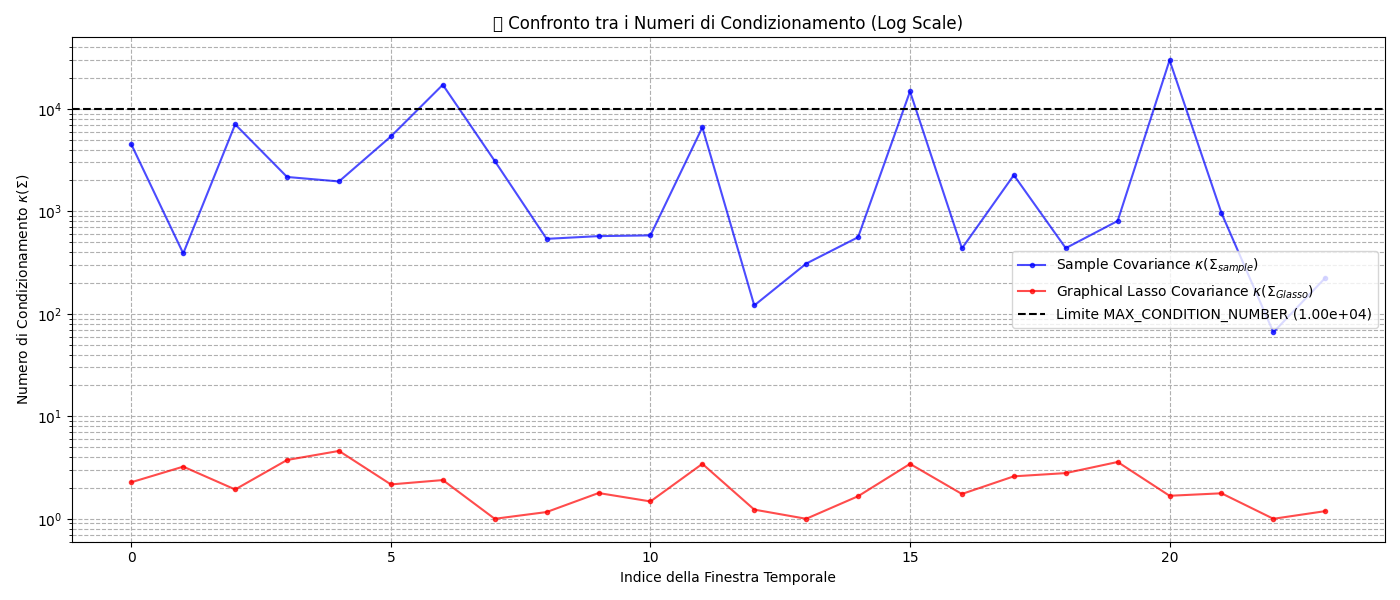


--- Analisi Dettagliata del Condizionamento ---
Limite MAX_CONDITION_NUMBER utilizzato: 1.00e+04
Numero totale di finestre: 24
----------------------------------------
Finestre mal condizionate (Campione): 3 (12.50%)
Finestre mal condizionate (Glasso): 0 (0.00%)


In [11]:
# Cell 4: Covariance and precision estimation per window (sample and Glasso)
# Adds a condition-number check before attempting to invert the sample covariance.

MAX_CONDITION_NUMBER = 1e4  # threshold to consider a matrix "well-conditioned"


def compute_cov_prec_for_window(window_returns, alpha):
    """
    Given a returns window (T x N), standardize it, then:
    - compute the sample covariance of standardized data
    - compute the inverse (precision) of the sample covariance, but only if it is
      sufficiently well-conditioned (based on the condition number)
    - compute a Ledoit–Wolf covariance for input to Graphical Lasso
    - apply Graphical Lasso to obtain a regularized covariance + precision

    Returns
    -------
    sample_cov : (N, N) ndarray
        Sample covariance matrix of standardized returns.
    sample_prec : (N, N) ndarray or None
        Inverse (precision) of sample_cov. Uses pseudo-inverse if poorly conditioned,
        or None if even pseudo-inverse fails.
    glasso_cov : (N, N) ndarray
        Covariance matrix estimated by Graphical Lasso.
    glasso_prec : (N, N) ndarray
        Precision matrix estimated by Graphical Lasso.
    """
    # --- STANDARDIZE RETURNS IN THE WINDOW ---
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)  # shape: (T, N)

    # --- UNREGULARIZED SAMPLE COVARIANCE ---
    sample_cov = np.cov(X, rowvar=False)  # shape: (N, N)

    # --- CONDITION NUMBER CHECK ---
    try:
        cond_sample = np.linalg.cond(sample_cov) # 2-norm, computed directly using the SVD
    except np.linalg.LinAlgError as e:
        print(
            "Warning: could not compute condition number for sample covariance "
            f"in this window. Treating it as ill-conditioned.\n  Details: {e}"
        )
        cond_sample = np.inf
    

    sample_prec = None
    is_well_conditioned = np.isfinite(cond_sample) and cond_sample < MAX_CONDITION_NUMBER


    try:
        sample_prec = np.linalg.inv(sample_cov)
    except np.linalg.LinAlgError as e:
        print(
            "Warning: sample covariance appears well-conditioned "
            f"(cond={cond_sample:.2e}) but inversion failed;\n"
            f"  Details: {e}"
        )
        sample_prec = None


    # --- LEDOIT–WOLF COVARIANCE FOR GLASSO INPUT ---
    # We use standardized data and assume it is centered.
    emp_cov, _ = ledoit_wolf(X, assume_centered=True)

    # --- GRAPHICAL LASSO ---
    glasso_cov, glasso_prec = graphical_lasso(emp_cov, alpha=alpha, tol=1e-4)
    
    cond_glasso = np.linalg.cond(glasso_cov)
    
    print(f"Sample Var. conditioning: {cond_sample}\n Glasso Var. conditioning: {cond_glasso}")

    return sample_cov, cond_sample, sample_prec, glasso_cov, cond_glasso, glasso_prec


# Run estimation on all windows
sample_covs = []
sample_precs = []   # list of sample precision matrices (or None)
cond_sample = []
glasso_covs = []
glasso_precs = []   # list of Glasso precision matrices
cond_glasso = []

for idx, win in enumerate(windows):
    s_cov, s_cond, s_prec, g_cov, g_cond, g_prec = compute_cov_prec_for_window(win, ALPHA)
    sample_covs.append(s_cov)
    cond_sample.append(s_cond)
    sample_precs.append(s_prec)
    glasso_covs.append(g_cov)
    cond_glasso.append(g_cond)
    glasso_precs.append(g_prec)

print("Covariance and precision matrices computed.")
print("  number of windows:", len(sample_covs))
if len(sample_covs) > 0:
    print("  covariance matrix shape:", sample_covs[0].shape)
    
    

# --- 2. Funzione di Plotting e Analisi ---

window_indices = np.arange(len(cond_sample))

plt.figure(figsize=(14, 6))

# Plot dei valori di condizionamento campionari
plt.plot(window_indices, cond_sample, label='Sample Covariance $\\kappa(\\Sigma_{sample})$', marker='.', linestyle='-', color='blue', alpha=0.7)

# Plot dei valori di condizionamento Glasso
plt.plot(window_indices, cond_glasso, label='Graphical Lasso Covariance $\\kappa(\\Sigma_{Glasso})$', marker='.', linestyle='-', color='red', alpha=0.7)

# Linea orizzontale per il limite di mal condizionamento
plt.axhline(MAX_CONDITION_NUMBER, color='k', linestyle='--', label=f'Limite MAX_CONDITION_NUMBER ({MAX_CONDITION_NUMBER:.2e})')

# Impostazioni del grafico
plt.yscale('log') # Usa una scala logaritmica per vedere i grandi valori
plt.title('📈 Confronto tra i Numeri di Condizionamento (Log Scale)')
plt.xlabel('Indice della Finestra Temporale')
plt.ylabel('Numero di Condizionamento $\\kappa(\\Sigma)$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- 3. Analisi del Condizionamento ---

# Controlla per i valori mal condizionati (condizionamento > Limite)
num_windows = len(window_indices)
num_sample_ill = np.sum(np.array(cond_sample) > MAX_CONDITION_NUMBER)
num_glasso_ill = np.sum(np.array(cond_glasso) > MAX_CONDITION_NUMBER)

print("\n--- Analisi Dettagliata del Condizionamento ---")
print(f"Limite MAX_CONDITION_NUMBER utilizzato: {MAX_CONDITION_NUMBER:.2e}")
print(f"Numero totale di finestre: {num_windows}")
print("-" * 40)
print(f"Finestre mal condizionate (Campione): {num_sample_ill} ({num_sample_ill / num_windows * 100:.2f}%)")
print(f"Finestre mal condizionate (Glasso): {num_glasso_ill} ({num_glasso_ill / num_windows * 100:.2f}%)")


In [12]:
# Cell 5: Frobenius norm differences across consecutive windows

def frobenius_differences(cov_list):
    """
    Compute Frobenius norm of differences between consecutive
    covariance matrices in `cov_list`.
    """
    diffs = []
    for i in range(len(cov_list) - 1):
        delta = cov_list[i+1] - cov_list[i]
        frob = np.linalg.norm(delta, ord='fro')
        diffs.append(frob)
    return np.array(diffs)

fro_sample = frobenius_differences(sample_covs)
fro_glasso = frobenius_differences(glasso_covs)

# Build a DataFrame for easier inspection
window_pairs = []
for i in range(len(windows) - 1):
    w1 = windows[i]
    w2 = windows[i+1]
    label = f"{w1.index[0].date()}–{w1.index[-1].date()} -> {w2.index[0].date()}–{w2.index[-1].date()}"
    window_pairs.append(label)

results_df = pd.DataFrame({
    "window_pair": window_pairs,
    "frobenius_sample": fro_sample,
    "frobenius_glasso": fro_glasso,
})

print("Frobenius differences between consecutive windows:")
print(results_df.head())
print("\nSummary statistics:")
print("  mean(sample) :", results_df["frobenius_sample"].mean())
print("  mean(glasso) :", results_df["frobenius_glasso"].mean())
print("  std(sample)  :", results_df["frobenius_sample"].std())
print("  std(glasso)  :", results_df["frobenius_glasso"].std())


Frobenius differences between consecutive windows:
                                      window_pair  frobenius_sample  \
0  2023-01-04–2023-01-18 -> 2023-01-19–2023-02-01          3.811830   
1  2023-01-19–2023-02-01 -> 2023-02-02–2023-02-15          3.192724   
2  2023-02-02–2023-02-15 -> 2023-02-16–2023-03-02          3.085255   
3  2023-02-16–2023-03-02 -> 2023-03-03–2023-03-16          2.064079   
4  2023-03-03–2023-03-16 -> 2023-03-17–2023-03-30          3.061494   

   frobenius_glasso  
0          0.924669  
1          0.873546  
2          1.005825  
3          0.782782  
4          1.438888  

Summary statistics:
  mean(sample) : 2.8062182292614404
  mean(glasso) : 0.7144547671654777
  std(sample)  : 0.6330532056676608
  std(glasso)  : 0.386196777960673


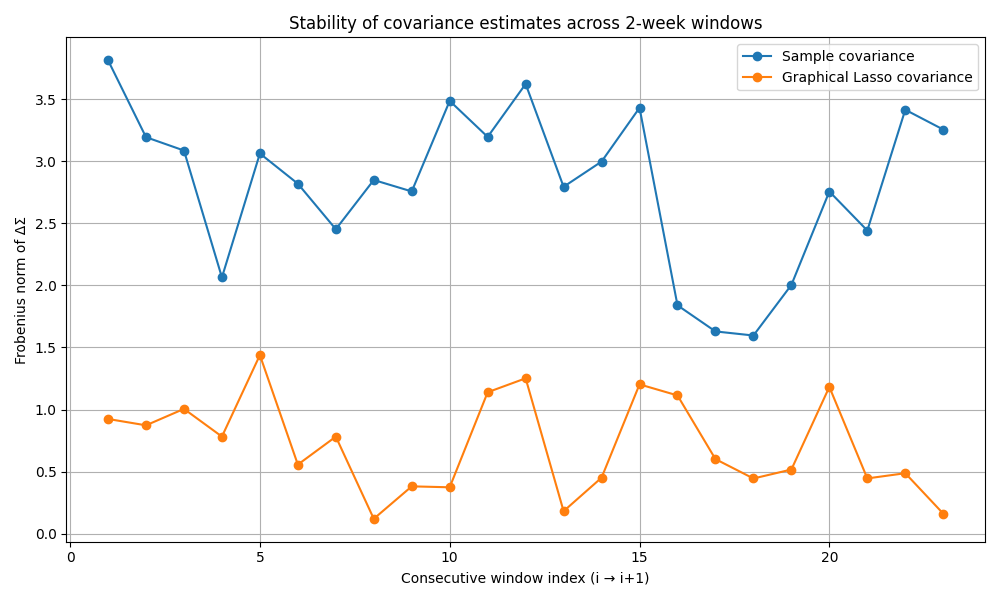

Stability comparison plot generated.


In [13]:
# Cell 6: Plot sample vs Glasso Frobenius norms

plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample) + 1)

plt.plot(x, fro_sample, marker='o', label="Sample covariance")
plt.plot(x, fro_glasso, marker='o', label="Graphical Lasso covariance")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Frobenius norm of ΔΣ")
plt.title("Stability of covariance estimates across 2-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Stability comparison plot generated.")


Frobenius differences between consecutive windows (PRECISION matrices):
  window_pair  frobenius_sample_prec  frobenius_glasso_prec
0         0→1             746.344761               0.772823
1         1→2            1255.420721               0.665249
2         2→3            1106.335269               0.772777
3         3→4             211.307324               0.680724
4         4→5             962.059009               1.044603

Summary statistics for precision matrices:
  mean(sample precision) : 1271.9613351474677
  mean(glasso precision) : 0.5998132919338627
  std(sample precision)  : 1610.646361521207
  std(glasso precision)  : 0.27791529481520144


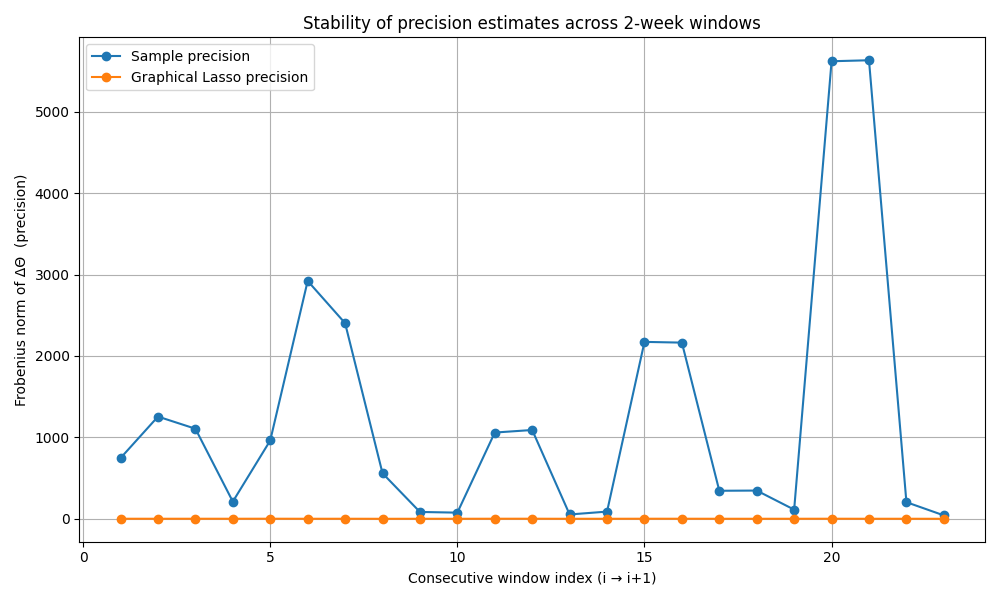

Precision stability comparison plot generated.
[ 746.34476086 1255.42072112 1106.33526918  211.30732414  962.05900902
 2921.3656205  2402.87011469  559.49313011   84.15231746   75.69968116
 1059.39671169 1090.7147589    53.19003299   88.48768065 2172.96716841
 2163.92282878  344.34812571  346.88227169  112.40866982 5619.75913883
 5631.91019964  204.13879579   41.93637724]
[0.77282324 0.66524935 0.7727769  0.68072439 1.04460328 0.51304859
 0.66634099 0.11652916 0.35747172 0.33507263 0.95232871 1.00718776
 0.18498096 0.39973973 0.9277907  0.85692964 0.52030714 0.42680598
 0.56113024 0.94036545 0.44963152 0.47946807 0.16439957]


In [14]:
# Cell 7: Frobenius norm differences for precision matrices (sample vs Glasso)

# Reuse the same helper; it works for any list of matrices (covariances or precisions)
fro_sample_prec = frobenius_differences(sample_precs)
fro_glasso_prec = frobenius_differences(glasso_precs)

# Label window pairs i -> i+1
window_pairs_prec = [f"{i}→{i+1}" for i in range(len(fro_sample_prec))]

prec_results_df = pd.DataFrame({
    "window_pair": window_pairs_prec,
    "frobenius_sample_prec": fro_sample_prec,
    "frobenius_glasso_prec": fro_glasso_prec,
})

print("Frobenius differences between consecutive windows (PRECISION matrices):")
print(prec_results_df.head())

print("\nSummary statistics for precision matrices:")
print("  mean(sample precision) :", prec_results_df["frobenius_sample_prec"].mean())
print("  mean(glasso precision) :", prec_results_df["frobenius_glasso_prec"].mean())
print("  std(sample precision)  :", prec_results_df["frobenius_sample_prec"].std())
print("  std(glasso precision)  :", prec_results_df["frobenius_glasso_prec"].std())

# Plot the stability over window pairs
plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample_prec) + 1)

plt.plot(x, fro_sample_prec, marker='o', label="Sample precision")
plt.plot(x, fro_glasso_prec, marker='o', label="Graphical Lasso precision")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Frobenius norm of ΔΘ  (precision)")
plt.title("Stability of precision estimates across 2-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Precision stability comparison plot generated.")


print(fro_sample_prec)
print(fro_glasso_prec)


**Interpretation**: Why Condition Number Drives Stability

In our code, we calculated $\kappa_2(\Sigma)$ using np.linalg.cond, which computes the ratio of the largest to the smallest singular value via SVD ($\sigma_{max} / \sigma_{min}$).

When we move from window $t$ to $t+1$, the input covariance matrix $\Sigma$ changes slightly (perturbation). The condition number tells us how much that small change is amplified when we compute the inverse (Precision Matrix $\Omega = \Sigma^{-1}$).The theoretical bound on relative error is:$$\frac{\|\Delta \Sigma^{-1}\|}{\|\Sigma^{-1}\|} \leq \kappa(\Sigma) \cdot \frac{\|\Delta \Sigma\|}{\|\Sigma\|}$$

**Numerical Example from Our Results**:
1. When $\kappa_2(\Sigma)$ ~20,000: a tiny $5\%$ change in the input data (rolling the window forward) can be amplified up to $20,000 \times 0.05 = 1,000$ times (100,000%) in the inverse matrix. This explains why our consecutive Frobenius differences for the sample precision are massive (mean ~1,272). The solution is numerically unstable and jumps wildly.
2. The Graphical Lasso (Well-Conditioned): The regularization forced $\kappa$ down to ~2 to 5.The Mechanism: With a $\kappa \approx 3$, a $5\%$ change in input results in only a $3 \times 0.05 = 0.15$ (15%) change in the inverse. 

Observed Result: Our observed Frobenius differences are very small. The estimate is robust and evolves smoothly over time.